# Imports

In [635]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from sklearn.neighbors import (NearestNeighbors, 
                               KNeighborsRegressor)

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import (train_test_split, 
                                     learning_curve,
                                     cross_validate,
                                     RandomizedSearchCV,
                                     GridSearchCV)

from sklearn.tree import (DecisionTreeRegressor, 
                          ExtraTreeRegressor)

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import (LinearRegression, 
                                  ElasticNet, 
                                  Ridge, 
                                  Lasso)

from sklearn.feature_selection import SelectKBest


from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   StandardScaler, 
                                   MaxAbsScaler,
                                   FunctionTransformer,
                                   OneHotEncoder,
                                   PolynomialFeatures) 

from sklearn.metrics import (r2_score,
                             mean_squared_error, 
                             mean_absolute_error,
                             SCORERS)

from matplotlib import pyplot as plt
import seaborn as sns

from eli5.sklearn import PermutationImportance
import eli5

In [3]:
warnings.filterwarnings('ignore') 

In [4]:
sns.set_style('darkgrid')

In [50]:
df = pd.read_csv('kc_house_data.csv')

In [6]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Feature Engineering

## Ajustes dos tipos de dados

In [51]:
#df.drop('id', axis = 1, inplace = True)
df.date = pd.to_datetime(df.date)
df.waterfront = df.waterfront.astype('bool')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.view = df.view.astype('category')
df.zipcode = df.zipcode.astype('object')

# df.yr_renovated = df.yr_renovated.replace(0, np.nan)
# df.yr_renovated = pd.to_datetime(df.yr_renovated, format = '%Y').dt.year

In [52]:
df['month'] = df.date.dt.month

## Criação de features

In [53]:
### Feature Engineering ###

df['bedbath']    = df.apply(lambda x: x.bedrooms/x.bathrooms if x.bathrooms > 0 else x.bedrooms, axis = 1)
df['renovated']  = df.yr_renovated.apply(lambda x: 1 if x>0 else 0)
df['flr_living'] = df.floors*df.sqft_living
df['livinglot']  = df.sqft_living/df.sqft_lot
df['lastbuild']  = df.apply(lambda x: (2022 - x.yr_renovated) if x.yr_renovated > 0 else (2022 - x.yr_built), axis =1)

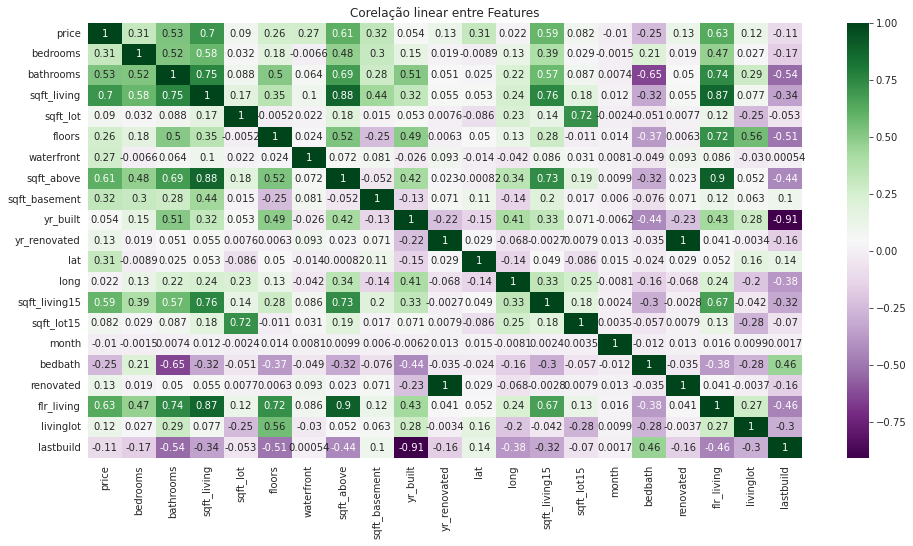

In [301]:
plt.figure(figsize = (16,8))
sns.heatmap(df.drop('id', axis = 1).corr(), annot = True, cmap = 'PRGn')
plt.title("Corelação linear entre Features")
plt.show()

## Definição de features input e target

In [504]:
df1 = df.copy()

In [143]:
X = df.drop(['zipcode','price','date', 'yr_renovated','yr_built', 'id'], axis = 1)
y = df.price

In [598]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True)

# Criação de Pipelines de Processamento e Modelagem

In [599]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [600]:
num_pipe = Pipeline(steps=[('log', FunctionTransformer(np.log1p)),
                           ('scaler', StandardScaler())])

In [601]:
ct = ColumnTransformer(transformers=[
    ('log', num_pipe, ['sqft_living','sqft_lot','floors','sqft_living15','sqft_lot15']),
    ('ohc', OneHotEncoder(), ['month'])
], remainder = 'passthrough')

## Teste de Modelos Baseline

In [602]:
mean_prediction_vector = (df.price.mean()*np.ones(y_test.shape[0]))

print(f'R2: {r2_score(y_test, mean_prediction_vector)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, mean_prediction_vector)),2)}')

R2: -0.0004121721171661541
RMSE: 386845.29


In [ ]:
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
regressors = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), DecisionTreeRegressor(), ExtraTreeRegressor(), KNeighborsRegressor()]
scores = []
for scaler in scalers:
    for regressor in regressors:
        pipe = Pipeline(steps = [('preprocessor', ct),
                                 ('modeling', regressor)])
        
        score = cross_validate(pipe, X=X_train, y=y_train, scoring = ['r2', 'neg_mean_squared_error'], cv=5)
        #adj_score = adjustedR2(score, X_train.shape[0], X_train.shape[1])
        print(regressor, scaler, score)

Melhor modelo observado: Random Forest Regressor e 

In [604]:
rlin_pipe = Pipeline(steps = [('preprocessor', ct_num),
                              ('poly', PolynomialFeatures(degree = 2)),
                              ('modeling', LinearRegression())
                             ])
        
scores = cross_validate(rlin_pipe, X=X_train, y=y_train, scoring = ['r2','neg_mean_squared_error'], cv=5)

print('Test_R2:  ', scores['test_r2'].mean(), scores['test_r2'].std())
print('Test_MSE:  ', np.sqrt(-scores['test_neg_mean_squared_error'].mean()), np.sqrt(scores['test_neg_mean_squared_error'].std()))
#score_sd = score.std()
#score = adjustedR2(score.mean(), X_train.shape[0], X_train.shape[1])

Test_R2:   0.7922700048033736 0.020202121811618436
Test_MSE:   163545.83744705038 38342.20797402785


In [605]:
rf_pipe = Pipeline(steps = [('preprocessor', ct),
                            ('modeling', RandomForestRegressor())
                           ])
        
scores = cross_validate(rf_pipe, X=X_train, y=y_train, scoring = ['r2','neg_mean_squared_error'], cv=5)

print('Test_R2:  ', scores['test_r2'].mean(), scores['test_r2'].std())
print('Test_MSE:  ', np.sqrt(-scores['test_neg_mean_squared_error'].mean()), np.sqrt(scores['test_neg_mean_squared_error'].std()))
#score_sd = score.std()
#score = adjustedR2(score.mean(), X_train.shape[0], X_train.shape[1])

Test_R2:   0.8739645499741469 0.009663858648771428
Test_MSE:   128182.07739993121 51715.31556819386


In [606]:
lc = learning_curve(rf_pipe, X_train, y_train, cv = 5, shuffle = True)

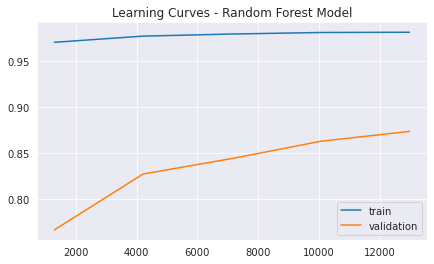

In [607]:
plt.figure(figsize=(7,4))
sns.lineplot(x=lc[0], y=np.mean(lc[1], axis = 1), label = 'train')
sns.lineplot(x=lc[0], y=np.mean(lc[2], axis = 1), label = 'validation')
plt.title('Learning Curves - Random Forest Model', fontsize = 12)
plt.legend()
plt.show()

A diferença entre o score de treino e validação revela um indício de overfitting no modelo Random Forest.

In [613]:
lc_reg = learning_curve(rlin_pipe, X_train, y_train, cv = 5, shuffle = True)

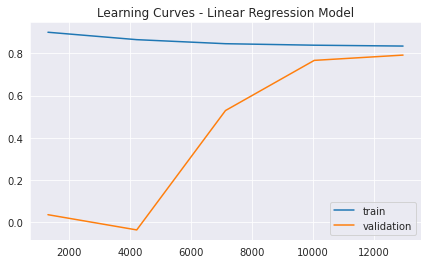

In [616]:
plt.figure(figsize=(7,4))
sns.lineplot(x=lc_reg[0], y=np.mean(lc_reg[1], axis = 1), label = 'train')
sns.lineplot(x=lc_reg[0], y=np.mean(lc_reg[2], axis = 1), label = 'validation')
plt.title('Learning Curves - Linear Regression Model', fontsize = 12)
plt.legend()
plt.show()

O mesmo não ocorre no modelo de Regressão Linear.

###### Há possibilidade de melhorar o modelo Random Forest reduzindo o overfitting

# Tunagem de Hiperparametros

In [618]:
rf_pipe.named_steps['modeling'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
RandomForestRegressor(max_dep)

In [628]:
grid = {'modeling__max_depth':[5,10,15, None],
        'modeling__max_features':['auto',7, 11,14],
        'modeling__min_samples_leaf':[1,5,10],
    }

In [629]:
rsearch = RandomizedSearchCV(rf_pipe, grid, cv = 5, scoring = 'neg_mean_squared_error', n_iter = 15)

In [636]:
gsearch = GridSearchCV(rf_pipe, grid, cv = 5, scoring = 'neg_mean_squared_error')

In [ ]:
rsearch.fit(X=X_train, y = y_train)

In [ ]:
gsearch.fit(X_train, y_train)

In [639]:
gsearch.best_params_

{'modeling__bootstrap': False,
 'modeling__ccp_alpha': 1,
 'modeling__max_depth': None,
 'modeling__max_features': 15,
 'modeling__min_samples_leaf': 1,
 'modeling__min_samples_split': 2}

In [644]:
gsearch.best_score_

-15947478034.920654

# Feature Importances

### Permutation Importance

In [ ]:
pipe = Pipeline(steps = [('preprocessor', ct_num),
                         ('scaler', StandardScaler()),
                         ('modeling', RandomForestRegressor())])
pipe.fit(X_train, y_train)

In [ ]:
perm = PermutationImportance(pipe)

In [ ]:
perm.fit(X_test, y_test)

In [ ]:
p_imp = pd.Series(perm.feature_importances_, index = X_test.columns)
p_imp.sort_values(ascending = False, inplace = True)

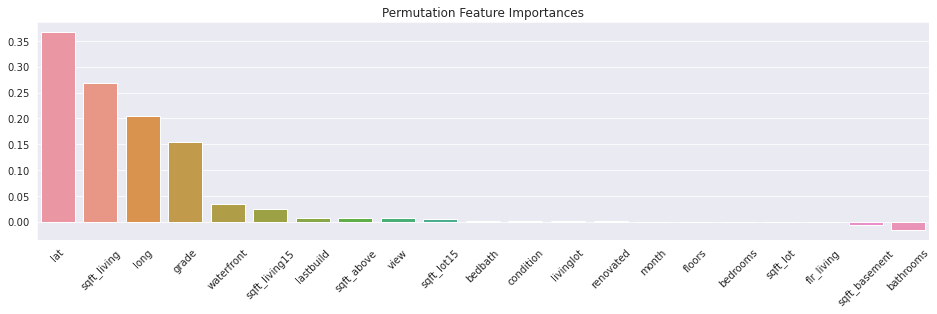

In [261]:
plt.figure(figsize=(16,4))
sns.barplot(x=p_imp.index, y= p_imp.values)
plt.xticks(rotation = 45)
plt.title('Permutation Feature Importances')
plt.show()

In [276]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3666 ± 0.0288,lat
0.2691 ± 0.0218,sqft_living
0.2046 ± 0.0294,long
0.1553 ± 0.0184,grade
0.0340 ± 0.0039,waterfront
0.0243 ± 0.0039,sqft_living15
0.0079 ± 0.0027,lastbuild
0.0068 ± 0.0009,sqft_above
0.0064 ± 0.0010,view
0.0055 ± 0.0009,sqft_lot15


### Random Forest Feature Importances

In [267]:
fi_indices = pipe.named_steps['modeling'].feature_importances_.argsort()

In [273]:
pipe.named_steps['modeling'].feature_importances_

array([0.25471655, 0.0105224 , 0.00084258, 0.02960742, 0.01245843,
       0.00195908, 0.01281635, 0.03344442, 0.01071653, 0.00277398,
       0.33013805, 0.0176076 , 0.0061019 , 0.16219852, 0.0703766 ,
       0.0060027 , 0.00570224, 0.00178477, 0.00957178, 0.0070727 ,
       0.01358539])

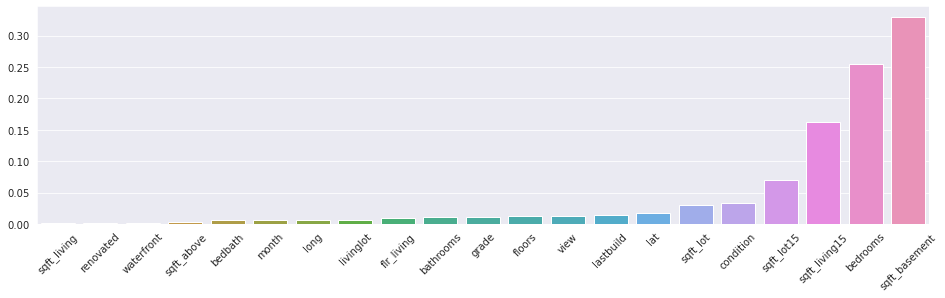

In [272]:
plt.figure(figsize=(16,4))
sns.barplot(x=X_train.columns[fi_indices], y=pipe.named_steps['modeling'].feature_importances_[fi_indices])
plt.xticks(rotation = 45)
plt.show()